# <span style="color:yellow">New Classes and Some Functions</span>

In [1]:
from TMclass import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree
from datetime import datetime as DT
from datetime import timedelta as TD

TM3 = {'date':[], 'tm_rate':[], 'duration':[]}
TM3n = {'date':[], 'tm_rate':[], 'duration':[]}
TM13 = {'date':[], 'tm_rate':[], 'duration':[]}

# you have to remove what is inside <eventfile>
with open('../SIFECS_NMP_Segment_2_withLTP10-11FECS.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM3['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM3['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM3['duration'] += [int(node.attrib.get('duration'))]

TM3['date'] = np.asarray(TM3['date'])
TM3['tm_rate'] = np.asarray(TM3['tm_rate'])
TM3['duration'] = np.asarray(TM3['duration'])

with open('../FECS_2023072_2023177_2022348130413_v03.SOL') as f:
	tree = ElementTree.parse(f)
for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM3n['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM3n['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM3n['duration'] += [int(node.attrib.get('duration'))]

TM3n['date'] = np.asarray(TM3n['date'])
TM3n['tm_rate'] = np.asarray(TM3n['tm_rate'])
TM3n['duration'] = np.asarray(TM3n['duration'])

with open('../SIFECS_SIFECS_LTP12-13_preFECS_Mission_Level_Plan_for_LTP12_and_13_2.xml') as f:
	tree = ElementTree.parse(f)
for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM13['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM13['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM13['duration'] += [int(node.attrib.get('duration'))]

TM13['date'] = np.asarray(TM13['date'])
TM13['tm_rate'] = np.asarray(TM13['tm_rate'])
TM13['duration'] = np.asarray(TM13['duration'])

idx0 = np.where(TM3['date'] > TM3n['date'][0])[0][0]
idx1 = np.where(TM3['date'] < TM3n['date'][-1])[0][-1]
TM3['date'] = np.concatenate((TM3['date'][:idx0],TM3n['date'],TM3['date'][idx1:]))
TM3['tm_rate'] = np.concatenate((TM3['tm_rate'][:idx0],TM3n['tm_rate'],TM3['tm_rate'][idx1:]))
TM3['duration'] = np.concatenate((TM3['duration'][:idx0],TM3n['duration'],TM3['duration'][idx1:]))

idx0 = np.where(TM3['date'] > TM13['date'][0])[0][0]
idx1 = np.where(TM3['date'] < TM13['date'][-1])[0][-1]
TM3['date'] = np.concatenate((TM3['date'][:idx0],TM13['date'],TM3['date'][idx1:]))
TM3['tm_rate'] = np.concatenate((TM3['tm_rate'][:idx0],TM13['tm_rate'],TM3['tm_rate'][idx1:]))
TM3['duration'] = np.concatenate((TM3['duration'][:idx0],TM13['duration'],TM3['duration'][idx1:]))

f = open('../phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [DT.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

# for i in range(np.size(TM3['date'])):
#     j = 0
#     if TM3['date'][i] >= TM3n['date'][0] and TM3['date'][i] <= TM3n['date'][-1]:
#         TM3['date'][i] = TM3n['date'][j]
#         TM3['tm_rate'][i] = TM3n['tm_rate'][j]
#         TM3['duration'][i] = TM3n['duration'][j]
#         j += 1

In [2]:
def flush_many(PHI,max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    # global PHI
    # global phi
    
    def _new_start(start,end):
        start += TD(days=1)
        start = start.replace(hour=22,minute=0,second=0)
        if end > start:
            start = end + TD(hours=1)
        return start
    
    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.level_out(level).n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); PHI.saving(partition,**kw)
    # start += TD(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = min(ndata - n0 - i*n1,n1),level=level); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)
    
def synoptic(PHI,mode,t0,t1,cadence,shape,nout,nbits,i,format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    # global PHI
    mode = PHI_mode(mode)
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
#     deltat = (t1 - t0)/N
    deltat = TD(minutes=cadence)
    
    min2 = TD(minutes=2)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min2,cadence=2,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw.crop',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.proc'); PHI.saving(i,**kw)
        else:
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.proc'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1
    return mode

def synoptic_raw(PHI,mode,t0,t1,cadence,shape,nbits,i, crop_pack = True, format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    # global PHI
    mode = PHI_MODE(mode)
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
#     deltat = (t1 - t0)/N
    deltat = TD(minutes=cadence)
    
    min2 = TD(minutes=2)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min2,cadence=2,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw');
            if crop_pack == False:
                PHI.saving(i,**kw)
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.pack'); PHI.saving(i,**kw)
        else:
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1
    return mode

def FDT_flat(PHI,t0,idx,proc='auto',flush='auto',verbose=True):

    # global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    FDTf1 = PHI_MODE('FDT')

    kw = FDTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = FDTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = FDTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = FDTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(FDTf1, label='FDT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return FDTf1

def HRT_flat(PHI,t0,idx,proc='auto',flush='auto',verbose=True):
    # global PHI
    proc_time = TD(minutes=15)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,10,cadence=40,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(kw['end'],ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def HRT_kll(PHI,t0,idx,proc='auto',flush='auto',verbose=True):
    # global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Kll Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def plot_flush_per_day(PHI,xlim=None, values=False):
    temp = PHI.part1.history    # plt.subplot(121)
    c1 = np.asarray(PHI.part1.history['compr'])
    c2 = np.asarray(PHI.part2.history['compr'])

    d1 = np.asarray(PHI.part1.history['start'])
    d2 = np.asarray(PHI.part2.history['start'])

    starttime = min(d1[0],d2[0])
    endtime = max(max(d1),max(d2))
    t0 = starttime
    times = []
    while starttime.date() <= endtime.date():
        times.append(starttime.date())
        starttime += datetime.timedelta(days=1)
    starttime = t0; del t0
    times_float = [(t - d1[0]).total_seconds() for t in d1]
    times = np.asarray(times)

    newc1 = np.zeros(np.size(times))
    for i,j in zip(d1,c1):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc1[ind] += j/1e3
    newc1 = np.asarray(newc1)

    newc2 = np.zeros(np.size(times))
    for i,j in zip(d2,c2):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc2[ind] += j/1e3
    newc2 = np.asarray(newc2)

    total = 0
    for i,t in enumerate(times):
        if t >= xlim[0].date() and t<= xlim[1].date():
            total += newc1[i] + newc2[i]

    plt.figure(figsize=(15,12))
    # plt.plot_date(times,newc1,color='blue',linestyle='-',marker='.',label='partition 1')
    # plt.plot_date(times,newc2,color='red',linestyle='-',marker='.',label='partition 2')
    plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')
    plt.gcf().autofmt_xdate()
    plt.grid()
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.ylabel('flush (GB/day)')

    if values:
        return times, newc1, newc2


(0.0, 4500.0)

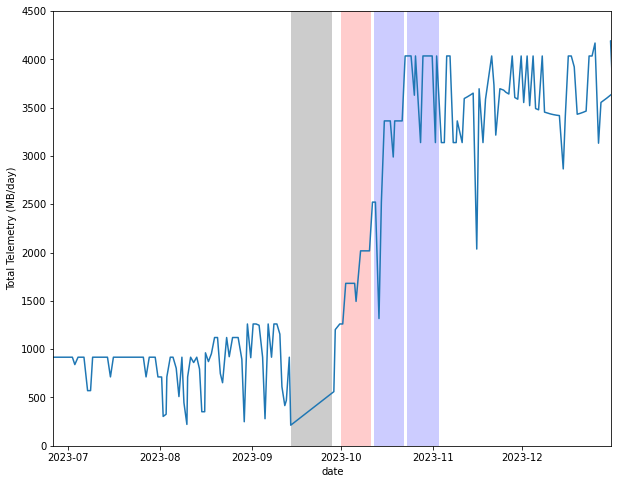

In [3]:
plt.figure(figsize=(10,8))
plt.plot(TM3['date'], (TM3['tm_rate']*TM3['duration'])/8/1e6)#; plt.ylim(0,5000)
plt.ylim(0,4500)
ylim = plt.gca().get_ylim()
plt.fill_betweenx(ylim,DT(2023,9,14),DT(2023,9,28),facecolor='black',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,10,1),DT(2023,10,11),facecolor='red',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,10,12),DT(2023,10,22),facecolor='blue',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,10,23),DT(2023,11,3),facecolor='blue',alpha=.2)
plt.xlim(datetime.date(2023,6,26),datetime.date(2023,12,31))
plt.ylabel('Total Telemetry (MB/day)')
plt.xlabel('date')
plt.ylim(ylim)

# TEST SYNOPTIC NOVEMBER

In [4]:
# (DT(2024,2,11)-DT(2023,11,30)).total_seconds()/60/60/24

In [5]:
# def simul_syn(cad = [4,4,4,4,4,4,4,4,4], bits = 6, outputs = 24, meta = 0.5):
#     """
#     1024: 04/11 - 12/11. 9d

#     896: 13/11 - 29/11. 17d

#     768: 30/11. - 11/02. 73d

#     896: 12/02 - 27/03. 16d

#     """

#     crop = [1024,896,768,896]
#     duration = [9,17,73,16]

#     cad = np.asarray(cad); crop = np.asarray(crop); duration = np.asarray(duration)
#     telemetry = duration * cad * (outputs * crop**2 * bits /8e6 + meta)

#     print(f"{crop[0]}: 04.26. - 05.01. {duration[0]}d: {cad[0]} datasets/day")
#     print(f"{crop[1]}: 05.02. - 05.14. {duration[1]}d: {cad[1]} datasets/day")
#     print(f"{crop[2]}: 05.15. - 05.23. {duration[2]}d: {cad[2]} datasets/day")
#     print(f"{crop[3]}: 05.24. - 06.15. {duration[3]}d: {cad[3]} datasets/day")
#     print(f"{crop[4]}: 06.16. - 08.05. {duration[4]}d: {cad[4]} datasets/day")
#     print(f"{crop[5]}: 08.06. - 08.25. {duration[5]}d: {cad[5]} datasets/day")
#     print(f"{crop[6]}: 08:26. - 09.05. {duration[6]}d: {cad[6]} datasets/day")
#     print(f"{crop[7]}: 09.06. - 09.17. {duration[7]}d: {cad[7]} datasets/day")
#     print(f"{crop[8]}: 09.18. - 09.23. {duration[8]}d: {cad[8]} datasets/day")
#     print(f"{crop[9]}: 09.24. - 09.28. {duration[9]}d: {cad[9]} datasets/day")

#     print('telemetry for each cropping run:',np.round(telemetry,1),'MB')
#     print('total telemetry:',np.round(telemetry.sum(),1),'MB')
#     # return telemetry


# # simul_syn([2,2,2,4,4,4,4,4,4,4])
# simul_syn([4,4,4,4,4,4,4,4,4,4])

In [17]:
t0 = DT(2023,11,14,12,0,0)
t1 = DT(2023,11,30,0,0,0)
t2 = DT(2023,12,5,12,0,0)
t3 = DT(2023,12,19,0,0,0)
t4 = DT(2023,12,25,0,0,0)
tend = DT(2024,1,1,0,0,0)

id = 1
PHI = PHI_MEMORY(t0-TD(days=1))

SYN1 = synoptic_raw(PHI,'FDT',t0,t1,120,(2048,896,4,6),6,id)
SYN2 = synoptic_raw(PHI,'FDT',t1,t2,120,(2048,768,4,6),6,id)
SYN3 = synoptic_raw(PHI,'FDT',t2,t3,180,(2048,768,4,6),6,id)
SYNH = synoptic_raw(PHI,'HRT',t3,t4,12*60,(2048,2048,4,6),6,id)
SYN4 = synoptic_raw(PHI,'FDT',t4,tend,180,(2048,768,4,6),6,id)


print('Total telemetry (no H/K) in',int((tend-t0).total_seconds()/60/60/24),'days:',roundup(PHI.part1.compr*1e6/2**20,1),'MiB')
print('Average telemetry (no H/K):',roundup(PHI.part1.compr*1e6/2**20/((tend-t0).total_seconds()/60/60/24),1),'MiB/day')
print('Memory used:',roundup(PHI.part1.occu/1e3,1),'GB')

Total telemetry (no H/K) in 21 days: 5838 MiB
Average telemetry (no H/K): 123 MiB/day
Memory used: 99 GB


In [5]:
T1 = DT(2023,11,13,0,0,0)
T2 = DT(2023,11,30,0,0,0)
id = 2
t0 = DT(2023,11,14,12,0,0)
th = t0+TD(days=7)
t1 = t0+TD(days=7*3)
t2 = t1+TD(days=7*4-1.5)
# th = t2-TD(days=7)
# PHI = PHI_MEMORY(t0-TD(days=1))

SYN = PHI_MODE('FDT')
SYNH = PHI_MODE('HRT')

# synoptic_raw(PHI,SYN,t0,T2,120,(2048,896,4,6),6,id)
# test with 1 week of HRT
synoptic_raw(PHI,SYNH,t0,th,12*60,(2048,2048,4,6),6,id)
synoptic_raw(PHI,SYN,th,T2,120,(2048,896,4,6),6,id)

# synoptic_raw(PHI,EW1,T1,t1,120,(2048,896,4,6),6,id)
# synoptic_raw(PHI,EW1,T1,T2,120,(2048,896,4,6),6,id)
SYN = PHI_MODE('FDT')
synoptic_raw(PHI,SYN,T2,t1,120,(2048,768,4,6),6,id)

# synoptic_raw(PHI,EW1,t1,T2,240,(2048,896,4,6),6,id)
# synoptic_raw(PHI,EW1,T2,t2,240,(2048,768,4,6),6,id)

SYN = PHI_MODE('FDT')
synoptic_raw(PHI,SYN,t1,t2,180,(2048,768,4,6),6,id)
# test with 1 week of HRT
# synoptic_raw(PHI,SYN,t1,th,180,(2048,768,4,6),6,id)
# synoptic_raw(PHI,SYNH,th,t2,12*60,(2048,2048,4,6),6,id)


print('Total telemetry (no H/K) in',int((t2-t0).total_seconds()/60/60/24),'days:',roundup(PHI.part2.compr*1e6/2**20,1),'MiB')
print('Average telemetry (no H/K):',roundup(PHI.part2.compr*1e6/2**20/((t2-t0).total_seconds()/60/60/24),1),'MiB/day')
print('Memory used:',roundup(PHI.part2.occu/1e3,1),'GB')

Pleas insert a valid mode: HRT, FDT, CALIB or FLUSH


AttributeError: 'PHI_MODE' object has no attribute 'mode'

In [21]:
th0

datetime.datetime(2023, 12, 19, 0, 0)

In [22]:
T1 = DT(2023,11,13,0,0,0)
T2 = DT(2023,11,30,0,0,0)
id = 2
t0 = DT(2023,11,14,12,0,0)
th0 = DT(2023,12,19,0,0,0)
th = th0+TD(days=5)
t1 = t0+TD(days=7*3)
t2 = t1+TD(days=7*4-1.5)
# th = t2-TD(days=7)
PHI = PHI_MEMORY(t0-TD(days=1))

SYN = PHI_MODE('FDT')
SYNH = PHI_MODE('HRT')

# synoptic_raw(PHI,SYN,t0,T2,120,(2048,896,4,6),6,id)
# test with 1 week of HRT
synoptic_raw(PHI,'FDT',t0,T2,120,(2048,896,4,6),6,id)

# synoptic_raw(PHI,EW1,T1,t1,120,(2048,896,4,6),6,id)
# synoptic_raw(PHI,EW1,T1,T2,120,(2048,896,4,6),6,id)
SYN = PHI_MODE('FDT')
synoptic_raw(PHI,'FDT',T2,t1,120,(2048,768,4,6),6,id)

# synoptic_raw(PHI,EW1,t1,T2,240,(2048,896,4,6),6,id)
# synoptic_raw(PHI,EW1,T2,t2,240,(2048,768,4,6),6,id)

SYN = PHI_MODE('FDT')
synoptic_raw(PHI,'FDT',t1,th0,180,(2048,768,4,6),6,id)
synoptic_raw(PHI,'HRT',th0,th,12*60,(2048,2048,4,6),6,id)
# test with 1 week of HRT
# synoptic_raw(PHI,SYN,t1,th,180,(2048,768,4,6),6,id)
# synoptic_raw(PHI,SYNH,th,t2,12*60,(2048,2048,4,6),6,id)

SYN = PHI_MODE('FDT')
synoptic_raw(PHI,'FDT',th,t2,180,(2048,768,4,6),6,id)


print('Total telemetry (no H/K) in',int((t2-t0).total_seconds()/60/60/24),'days:',roundup(PHI.part2.compr*1e6/2**20,1),'MiB')
print('Average telemetry (no H/K):',roundup(PHI.part2.compr*1e6/2**20/((t2-t0).total_seconds()/60/60/24),1),'MiB/day')
print('Memory used:',roundup(PHI.part2.occu/1e3,1),'GB')

Total telemetry (no H/K) in 47 days: 5775 MiB
Average telemetry (no H/K): 122 MiB/day
Memory used: 99 GB


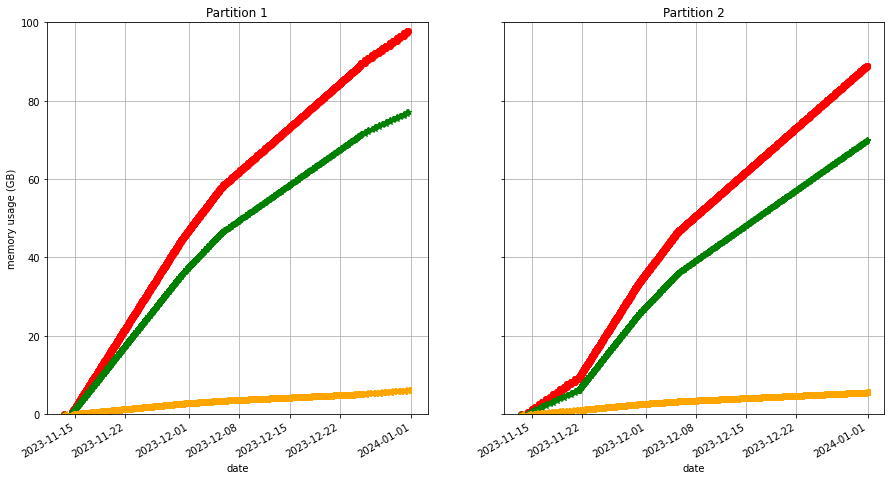

In [29]:
xlim = (DT(2023,11,1,0,0,0),DT(2023,12,31,0,0,0))
plot_tot(PHI, xlim=None, ylim=(0,100), time_ord=True)

# <span style="color:white">*out of RSWs*</span>

## <span style="color:blue">Synoptics</span>

CROP 1536


In [8]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-26T00:00:00')
# t1 = DT.fromisoformat('2023-09-30T00:00:00')
PHI = PHI_MEMORY(t0)

Syn = [PHI_MODE('FDT') for i in range(10)]
crop = [1408,1280,1024,896,768,896,1024,1280,1408,1536]
duration = [6,13,9,23,51,20,11,12,6,5]

cad = np.asarray([4,4,4,4,4,4,4,4,4,4]); 

for i,s in enumerate(Syn):
    cr = crop[i] 
    d = duration[i]
    c = 24/cad[i] * 60
    t1 = t0 + TD(days=d)
    kw = s.observation(t0,t1,c,(2048,cr,4,6)); PHI.saving(id,**kw)
    kw = s.cropping(kw['end'],cr,-1,'raw')
    if i > 3:
        id = 1
    kw = s.packing(kw['end'],-1,'raw.crop'); PHI.saving(id,**kw)
    kw = s.compressing(kw['end'],6,-1,'raw.crop.pack',); PHI.saving(id,**kw)
    id = 2
    t0 = t1
    printp(s, label='Synoptic')

########################################################


Synoptic
number of datasets: 24
cadence: 360.0 mins
duration: 6 days, 0:00:00
amount of raw-data at 32 bits: 6591.8 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 4577.6 MiB, 190.7 MiB per dataset
cropping time: 0:28:00
amount of pack-data at 16 bits: 2380.4 MiB, 99.2 MiB per dataset
packing time: 0:36:00
amount of compressed data + metadata at 6 bits: 824.8 MiB, 34.4 MiB per dataset
compressing (+ flushing) time: 1:55:18.555353
amount of metadata:  578.4 MiB
amount of memory usage: 13549.8 MiB

Synoptic
number of datasets: 52
cadence: 360.0 mins
duration: 13 days, 0:00:00
amount of raw-data at 32 bits: 13092.0 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 8331.3 MiB, 160.2 MiB per dataset
cropping time: 1:00:40
amount of pack-data at 16 bits: 4364.0 MiB, 83.9 MiB per dataset
packing time: 1:18:00
amount of compressed data + metadata at 6 bits: 1477.7 MiB, 28.4 MiB per dataset
compressing (+ flushing) time: 3:26:35.817574
amount 

## <span style="color:blue">L_FULL_LRES_MCAD_Probe-Quadrature</span>
FDT dataset are not in this box beacuse they are already in the synoptic, they are simply moved in time

In [6]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-27T04:05:00')
t1 = DT.fromisoformat('2023-10-27T23:00:00')
PB = PHI_MODE('HRT')
PHI = PHI_MEMORY(t0)

kw = PB.observation(t0,1,cadence=2,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = PB.observation(t0,2,cadence=180,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
# kw = FW1.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = PB.packing(DT(2023,11,15,5,0,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = PB.compressing(DT(2023,11,15,5,20,0),ndata=-1,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

########################################################
printp(PB, label='Probe QUadrature')


Probe QUadrature
number of datasets: 3
cadence: 180 mins
duration: 6:00:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 618.0 MiB, 206.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 217.8 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:30:27.022903
amount of metadata:  40.3 MiB
amount of memory usage: 1808.2 MiB



/home/calchetti/MPStemp/PHI_TMtool/TMclass.py:1210: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axi.plot_date(x,c,color='orange',linestyle='-',marker='<',label='compressed')


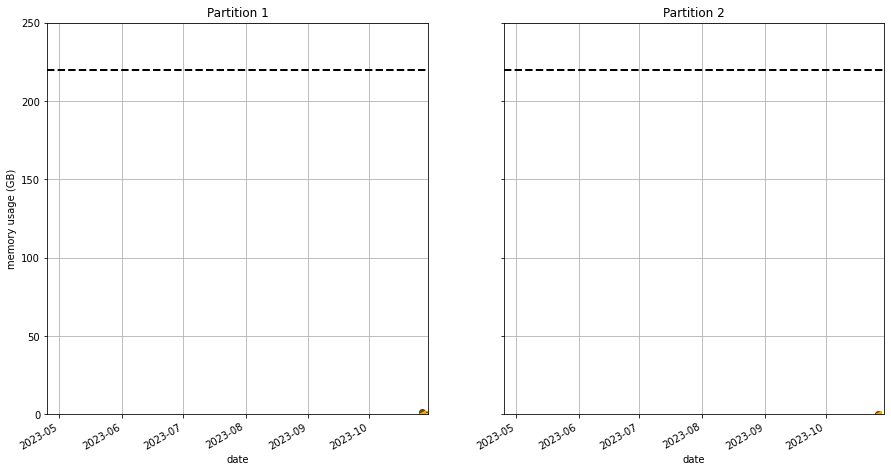

In [7]:
xlim = (DT(2023,4,25,0,0,0),DT(2023,10,30,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)

## <span style="color:magenta">***RESET NAND 2 (with Synoptics)***</span>

In [8]:
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')
# PHI.format_partition(1,DT(2023,1,29,16,0,0))
# PHI.format_partition(2,end + TD(hours=1))
# PHI.format_partition(1,end + TD(hours=1))
# PHI.format_partition(2,PHI.part1.history['end'][-1] + TD(hours=.5))
# PHI.format_partition(2,DT(2023,10,9,6,0,0))
PHI.format_partition(2,DT(2023,9,29,18,0,0))


amount of compressed data + metadata in partition 1: 0.23 GB
amount of compressed data + metadata in partition 2: 0.0 GB


## <span style="color:green">FDT Flat 1 </span>

In [9]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-09-30T21:30:00')
FDTflat1 = FDT_flat(PHI,t0,id,proc = 'auto', flush = DT(2023,11,15,0,15,0),verbose=False)
########################################################
printp(FDTflat1, label="FDT FLAT 1 (30/09/2023)")

FDT FLAT 1 (30/09/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.6 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:10:09.007634
amount of metadata:  16.1 MiB
amount of memory usage: 4173.3 MiB



# <span style="color:orange">*RSW 10*</span>

## <span style="color:blue">Coronal Dynamics 1</span>

In [10]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-01T00:00:00')
t1 = DT.fromisoformat('2023-10-05T06:00:00')
crop = 2048
CD1 = PHI_MODE('FDT')
kw = CD1.observation(t0,t1,cadence=360,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
# kw = CD1.cropping(DT(2023,11,15,1,0,0),crop=[crop,crop],ndata=-1,level='raw')#; PHI.saving(id,**kw)
kw = CD1.packing(DT(2023,11,14,0,30,0),ndata=-1,level='raw',); PHI.saving(id,**kw)
kw = CD1.compressing(DT(2023,11,15,0,30,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(id,**kw)

# synoptic_raw(PHI,CD1,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(CD1, label='Coronal Dynamics 1')


Coronal Dynamics 1
number of datasets: 17
cadence: 360 mins
duration: 4 days, 6:00:00
amount of raw-data at 32 bits: 6744.4 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 3501.9 MiB, 206.0 MiB per dataset
packing time: 0:25:30
amount of compressed data + metadata at 6 bits: 1234.2 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 2:52:33.129785
amount of metadata:  273.7 MiB
amount of memory usage: 10246.3 MiB



## <span style="color:blue">Density Fluctuations 1</span>

In [11]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-05T08:00:00')
t1 = DT.fromisoformat('2023-10-06T08:00:00')
DF1 = PHI_MODE('FDT')
crop = 2048

kw = DF1.observation(t0,t1,cadence=360,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
# kw = DF1.cropping(DT(2023,11,15,1,0,0),crop=[crop,crop],ndata=-1,level='raw')#; PHI.saving(id,**kw)
kw = DF1.packing(DT(2023,11,14,2,30,0),ndata=-1,level='raw',); PHI.saving(id,**kw)
kw = DF1.compressing(DT(2023,11,15,1,30,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(id,**kw)

# synoptic_raw(PHI,DF1,t0,t1,360,(2048,2048,4,6),6,id)

########################################################
printp(DF1, label='Density Fluctuations 1')


Density Fluctuations 1
number of datasets: 4
cadence: 360 mins
duration: 1 day, 0:00:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 824.0 MiB, 206.0 MiB per dataset
packing time: 0:06:00
amount of compressed data + metadata at 6 bits: 290.4 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:40:36.030538
amount of metadata:  64.4 MiB
amount of memory usage: 2410.9 MiB



## <span style="color:green">HRT Flat 1</span>

In [12]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-10-05T22:00:00')
HRTflat1 = HRT_flat(PHI,t0,id,flush=DT(2023,11,15,0,30,0),verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 1 (05/10/2023)")

HRT FLAT 1 (05/10/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.6 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:10:09.007634
amount of metadata:  16.1 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:blue">RS-burst 1 / Azaymi / QS</span> <br>

In [13]:

t0 = DT.fromisoformat('2023-10-06T10:00:00')
t1 = DT.fromisoformat('2023-10-06T14:30:00')
id = 1
crop = 1280

L2 = PHI_MODE('HRT')
kw = L2.observation(t0,t0+TD(minutes=30),cadence=100/60,shape=(2048,crop,4,6)); PHI.saving(1,**kw)
kw = L2.observation(kw['end'],kw['end']+TD(minutes=90),cadence=5,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

kw = L2.cropping(DT(2023,11,15,1,0,0),crop=[crop,crop],ndata=-1,level='raw')#; PHI.saving(id,**kw)
kw = L2.packing(DT(2023,11,15,1,0,0),ndata=-1,level='raw.crop',); PHI.saving(id,**kw)
kw = L2.compressing(kw['end']+TD(minutes=15),ndata=-1,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)



printp(L2, label='RS Burst 1')

RS Burst 1
number of datasets: 36
cadence: 5 mins
duration: 1:30:00
amount of raw-data at 32 bits: 9063.7 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 5767.8 MiB, 160.2 MiB per dataset
cropping time: 0:42:00
amount of pack-data at 16 bits: 3021.2 MiB, 83.9 MiB per dataset
packing time: 0:54:00
amount of compressed data + metadata at 6 bits: 1023.0 MiB, 28.4 MiB per dataset
compressing (+ flushing) time: 2:23:01.719859
amount of metadata:  723.6 MiB
amount of memory usage: 17852.8 MiB



## <span style="color:blue">Connection Mosaic</span>

6 pointings (?)

12 datasets (6 pointings, 2 datasets each)

In [14]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-06T18:00:00')
t1 = DT.fromisoformat('2023-10-08T11:30:00')
CM1 = PHI_MODE('HRT')

#cadence from 30 to 60 for putting 3h high cadence
kw = CM1.observation(t0,12,cadence=60*3,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
# kw = CM1.binning(kw['end']+TD(minutes=5),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = CM1.packing(DT(2023,11,15,4,0,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
# CM1, kw = flush_many(PHI,[1200,1200],72,CM1,DT(2023,4,3,22,0,0),6,-1,'raw.pack',id)
kw = CM1.compressing(DT(2023,11,15,4,12,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(id,**kw)

########################################################
printp(CM1, label='Connection Mosaic')


Connection Mosaic
number of datasets: 12
cadence: 180 mins
duration: 1 day, 12:00:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2471.9 MiB, 206.0 MiB per dataset
packing time: 0:18:00
amount of compressed data + metadata at 6 bits: 871.2 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 2:01:48.091613
amount of metadata:  193.2 MiB
amount of memory usage: 7232.7 MiB



## <span style="color:blue">Fast Wind 1</span>


In [15]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-08T20:30:00')
t1 = DT.fromisoformat('2023-10-09T21:30:00')
FW1 = PHI_MODE('HRT')

kw = FW1.observation(t0,2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
# kw = FW1.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW1.packing(DT(2023,11,15,5,0,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW1.compressing(DT(2023,11,15,5,20,0),ndata=2,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

kw = FW1.observation(t0+TD(days=1),2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
# kw = FW1.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW1.packing(DT(2023,11,15,5,10,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW1.compressing(DT(2023,11,15,5,45,0),ndata=2,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

########################################################
printp(FW1, label='Fast Wind 1')


Fast Wind 1
number of datasets: 4
cadence: 30 mins
duration: 1:00:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 824.0 MiB, 206.0 MiB per dataset
packing time: 0:06:00
amount of compressed data + metadata at 6 bits: 290.4 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:40:36.030538
amount of metadata:  32.2 MiB
amount of memory usage: 2410.9 MiB



## <span style="color:blue">RS-burst 2 / Sudip / AR</span> <br>

crop to 1280x1280

In [16]:

t0 = DT.fromisoformat('2023-10-10T08:00:00')
t1 = DT.fromisoformat('2023-10-10T11:30:00')
id = 1
crop = 2048

L1 = PHI_MODE('HRT')
kw = L1.observation(t0,t0+TD(minutes=60),cadence=100/60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = L1.observation(kw['end'],kw['end']+TD(minutes=90),cadence=5,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

ndata = [51,3]
for i in range(2):    
    # kw = L1.cropping(DT(2023,10,6,19,0,0)+TD(days=i),crop=[crop,crop],ndata=ndata[i],level='raw')#; PHI.saving(id,**kw)
    kw = L1.packing(DT(2023,11,22,0,15,0)+TD(days=7*i),ndata=ndata[i],level='raw',); PHI.saving(id,**kw)
    kw = L1.compressing(kw['end']+TD(minutes=5),ndata=ndata[i],nbits=6,level='raw.pack'); PHI.saving(id,**kw)


printp(L1, label='RS Burst 1')

RS Burst 1
number of datasets: 54
cadence: 5 mins
duration: 1:30:00
amount of raw-data at 32 bits: 21423.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 11123.7 MiB, 206.0 MiB per dataset
packing time: 1:21:00
amount of compressed data + metadata at 6 bits: 3920.4 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 9:08:06.412259
amount of metadata:  168.3 MiB
amount of memory usage: 32547.0 MiB



## <span style="color:blue">L_SMALL_MRES_MCAD_Earth-Quadrature</span>
<span style="color:red">crop to 1536 px to save telemetry</span>

In [17]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-10T20:30:00')
t1 = DT.fromisoformat('2023-10-11T00:00:00')
EQ = PHI_MODE('HRT')
crop = 1536

# cadence 60s to 100s to get some telemetry for high cadence
kw = EQ.observation(t0,1,cadence=2,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = EQ.cropping(DT(2023,11,29,3,15,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = EQ.packing(kw['end']+TD(minutes=2),ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = EQ.compressing(kw['end']+TD(minutes=2),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(EQ, label='Earth Quadrature')


Earth Quadrature
number of datasets: 1
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 297.5 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 228.9 MiB, 228.9 MiB per dataset
cropping time: 0:01:10
amount of pack-data at 16 bits: 122.1 MiB, 122.1 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 40.9 MiB, 40.9 MiB per dataset
compressing (+ flushing) time: 0:05:42.916794
amount of metadata:  24.1 MiB
amount of memory usage: 648.5 MiB



## <span style="color:green">FDT Flat 2</span>

Download raw flats

In [18]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-10-11T01:00:00')
FDTflat2 = FDT_flat(PHI,t0,id,DT(2023,10,26,2,30,0),DT(2023,11,29,4,20,0),verbose=False)
kw = FDTflat2.packing(DT(2023,11,29,4,45,0),ndata=9,level = 'raw'); PHI.saving(id,**kw)
kw = FDTflat2.compressing(kw['end']+TD(minutes=5),ndata=-1,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
# kw = FDTflat2.compressing(DT(2023,10,27,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
# kw = FDTflat2.compressing(DT(2023,10,28,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

########################################################
printp(FDTflat2, label="FDT FLAT 2 (11/10/2023)")

FDT FLAT 2 (11/10/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 726.0 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 1:41:30.076344
amount of metadata:  80.9 MiB
amount of memory usage: 6027.2 MiB



## <span style="color:green">FDT Flat 3</span>

Download raw flats

In [19]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-10-11T01:00:00')
FDTflat3 = FDT_flat(PHI,t0,id,DT(2023,11,28,2,30,0),DT(2023,11,29,6,20,0),verbose=False)
kw = FDTflat3.packing(DT(2023,11,29,6,45,0),ndata=9,level = 'raw'); PHI.saving(id,**kw)
kw = FDTflat3.compressing(kw['end']+TD(minutes=5),ndata=-1,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
# kw = FDTflat3.compressing(DT(2023,10,27,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
# kw = FDTflat3.compressing(DT(2023,10,28,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

########################################################
printp(FDTflat3, label="FDT FLAT 3 (11/10/2023)")

FDT FLAT 3 (11/10/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 726.0 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 1:41:30.076344
amount of metadata:  80.9 MiB
amount of memory usage: 6027.2 MiB



## <span style="color:green">HRT Flat 2</span>

In [20]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-10-11T10:00:00')
HRTflat2 = HRT_flat(PHI,t0,id,DT(2023,11,28,3,30,0),DT(2023,11,29,7,20,0),verbose=False)
########################################################
printp(HRTflat2, label="HRT FLAT 2 (11/10/2023)")

HRT FLAT 2 (11/10/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.6 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:10:09.007634
amount of metadata:  16.1 MiB
amount of memory usage: 4570.0 MiB



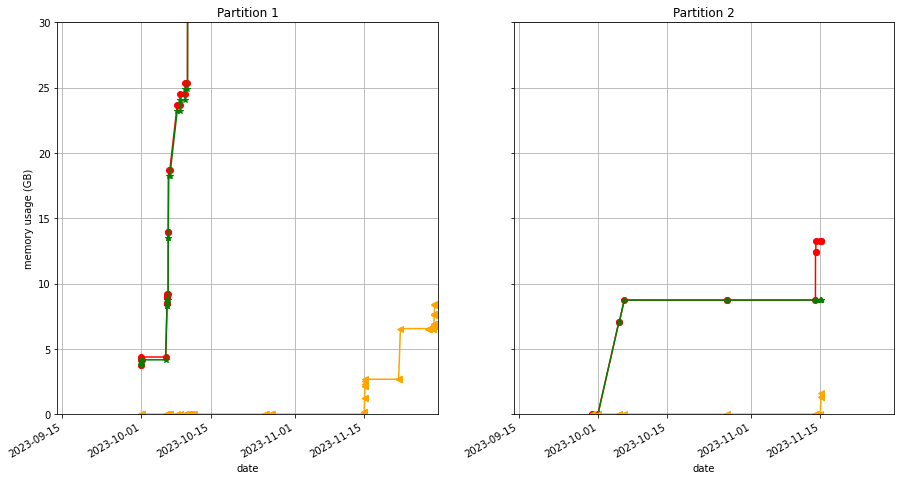

In [21]:
xlim = (DT(2023,9,14,0,0,0),DT(2023,11,30,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,30), time_ord=True)


# <span style="color:red">*RSW 11*</span>

## <span style="color:blue">R_SMALL_MRES_MCAD_AR-Long-Term</span> <br>

In [22]:
t0 = DT.fromisoformat('2023-10-12T00:00:00')
t1 = DT.fromisoformat('2023-10-17T11:30:00')
id = 1
crop = 1792

AR1 = PHI_MODE('HRT')
kw = AR1.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

t0 = DT.fromisoformat('2023-10-17T21:30:00')
t1 = DT.fromisoformat('2023-10-20T00:00:00')

kw = AR1.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

# 1 day test for LCT: 1h cadence, two datasets one after the other --> 24 more datasets
kw = AR1.observation(DT(2023,10,18,0,0,2),24,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

for i in range(3):
    kw = AR1.cropping(DT(2023,12,6,0,15,0)+TD(days=7*i),crop=[crop,crop],ndata=67,level='raw')#; PHI.saving(id,**kw)
    kw = AR1.packing(kw['end']+TD(minutes=5),ndata=67,level='raw.crop',); PHI.saving(id,**kw)
    kw = AR1.compressing(kw['end']+TD(minutes=5),ndata=67,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

# kw = AR1.cropping(DT(2023,12,20,14,0,0),crop=[crop,crop],ndata=4,level='raw')#; PHI.saving(id,**kw)
# kw = AR1.packing(kw['end']+TD(minutes=5),ndata=4,level='raw.crop',); PHI.saving(id,**kw)
# kw = AR1.compressing(kw['end']+TD(minutes=5),ndata=4,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

printp(AR1, label='AR Long Term 1')

AR Long Term 1
number of datasets: 205
cadence: 60 mins
duration: 1 day, 0:00:00
amount of raw-data at 32 bits: 71945.2 MiB, 351.0 MiB per dataset
crop size: 1792
amount of crop-data at 32 bits: 61340.3 MiB, 305.2 MiB per dataset
cropping time: 3:54:30
amount of pack-data at 16 bits: 32203.7 MiB, 160.2 MiB per dataset
packing time: 5:01:30
amount of compressed data + metadata at 6 bits: 11176.9 MiB, 55.6 MiB per dataset
compressing (+ flushing) time: 1 day, 2:02:38.252994
amount of metadata:  1270.7 MiB
amount of memory usage: 165489.2 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_Polar-Observations</span>

In [23]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-17T11:30:00')
t1 = DT.fromisoformat('2023-10-17T20:30:00')
polar1 = PHI_MODE('HRT')
crop = 1536

# cadence 20m to 30m to get some telemetry for high cadence
kw = polar1.observation(t0,DT(2023,10,17,14,30,0),cadence=20,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = polar1.observation(DT(2023,10,17,14,30,0),DT(2023,10,17,15,20,0),cadence=10,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = polar1.observation(DT(2023,10,17,15,20,0),DT(2023,10,17,15,40,0),cadence=100/60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = polar1.observation(DT(2023,10,17,15,40,0),DT(2023,10,17,20,30,0),cadence=10,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = polar1.cropping(DT(2023,11,28,11,20,0),crop=crop,ndata=-1,level = 'raw');# PHI.saving(id,**kw)
kw = polar1.packing(DT(2023,11,28,12,20,0),ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = polar1.compressing(DT(2023,11,29,10,20,0),ndata=44,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
kw = polar1.compressing(DT(2024,1,31,10,20,0),ndata=-1,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
# kw = polar1.compressing(DT(2023,10,23,18,0,0),ndata=15,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
# kw = polar1.compressing(DT(2023,10,24,18,0,0),ndata=15,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
# kw = polar1.compressing(DT(2023,10,25,18,0,0),ndata=16,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(polar1, label='Polar Observations')


Polar Observations
number of datasets: 55
cadence: 10 mins
duration: 4:50:00
amount of raw-data at 32 bits: 16365.1 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 12588.5 MiB, 228.9 MiB per dataset
cropping time: 1:04:10
amount of pack-data at 16 bits: 6713.9 MiB, 122.1 MiB per dataset
packing time: 1:22:30
amount of compressed data + metadata at 6 bits: 2248.3 MiB, 40.9 MiB per dataset
compressing (+ flushing) time: 5:14:20.423690
amount of metadata:  1113.1 MiB
amount of memory usage: 35667.4 MiB



## <span style="color:magenta">***RESET NAND 1***</span>

In [27]:
# print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
# PHI.format_partition(1,DT(2023,10,20,1,0,0))

## <span style="color:blue">R_SMALL_HRES_HCAD_Atmospheric-Dynamics-Structure</span> <br>

In [28]:
t0 = DT.fromisoformat('2023-10-20T07:00:00')
t1 = DT.fromisoformat('2023-10-20T13:00:00')
id = 2
crop = 1536 # 1536 # 1280 # 

ADS = PHI_MODE('HRT')
kw = ADS.observation(t0,t1,cadence=1,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

for i in range(4):
    kw = ADS.cropping(DT(2023,12,27,9,0,0)+TD(days=7*i),[crop,crop],ndata=90,level='raw');# PHI.saving(id,**kw)
    kw = ADS.packing(kw['end'],ndata=90,level='raw.crop',); PHI.saving(id,**kw)
    kw = ADS.compressing(kw['end']+TD(minutes=15),ndata=90,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

printp(ADS,label='ATMOSPHERIC-DYNAMICS-STRUCTURE')

ATMOSPHERIC-DYNAMICS-STRUCTURE
number of datasets: 360
cadence: 1 mins
duration: 6:00:00
amount of raw-data at 32 bits: 107116.7 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 82397.5 MiB, 228.9 MiB per dataset
cropping time: 7:00:00
amount of pack-data at 16 bits: 43945.3 MiB, 122.1 MiB per dataset
packing time: 9:00:00
amount of compressed data + metadata at 6 bits: 14716.4 MiB, 40.9 MiB per dataset
compressing (+ flushing) time: 1 day, 10:17:30.045972
amount of metadata:  4329.0 MiB
amount of memory usage: 233459.5 MiB



## <span style="color:blue">LIMB (STIX+METIS)</span>
<span style="color:red">crop to 1536 px to save telemetry</span>

In [29]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-20T16:00:00')
t1 = DT.fromisoformat('2023-10-21T00:00:00')
LI = PHI_MODE('HRT')
crop = 1536

# cadence 60s to 100s to get some telemetry for high cadence
kw = LI.observation(t0,1,cadence=2,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = LI.observation(t0+TD(hours=3),1,cadence=2,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = LI.observation(t0+TD(hours=6),1,cadence=2,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = LI.cropping(DT(2024,1,24,0,15,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = LI.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = LI.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(LI, label='Limb (STIX + METIS)')


Limb (STIX + METIS)
number of datasets: 3
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 892.6 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 686.6 MiB, 228.9 MiB per dataset
cropping time: 0:03:30
amount of pack-data at 16 bits: 366.2 MiB, 122.1 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 122.6 MiB, 40.9 MiB per dataset
compressing (+ flushing) time: 0:17:08.750383
amount of metadata:  56.3 MiB
amount of memory usage: 1945.5 MiB



## <span style="color:blue">L_BOTH_HRES_LCAD_CH-Boundary-Expansion</span>

In [30]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-21T00:00:00')
t1 = DT.fromisoformat('2023-10-22T00:00:00')
CH1 = PHI_MODE('FDT')
crop = 1408
kw = CH1.observation(t0,t1,cadence=360,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = CH1.cropping(DT(2024,1,23,15,0,0),crop=[crop,crop],ndata=-1,level='raw')#; PHI.saving(id,**kw)
kw = CH1.packing(kw['end']+TD(minutes=10),ndata=-1,level='raw.crop',); PHI.saving(id,**kw)
kw = CH1.compressing(DT(2024,1,24,0,30,0),ndata=-1,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

# synoptic_raw(PHI,CH1,t0,t1,360,(2048,1408,4,6),6,id)

# 1h@1m cadence test
# crop = 1408
# kw = CH1.observation(t0+TD(hours=1),60,cadence=1,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
# for i in range(10):
#     kw = CH1.cropping(DT(2023,12,1,17,0,0)+TD(days=i),crop=crop,ndata=6,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
#     kw = CH1.packing(kw['end'],ndata=6,level = 'raw.crop'); PHI.saving(id,**kw)
#     kw = CH1.compressing(kw['end']+TD(minutes=60),ndata=6,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(CH1, label='CH boundary expansion')


CH boundary expansion
number of datasets: 4
cadence: 360 mins
duration: 1 day, 0:00:00
amount of raw-data at 32 bits: 1098.6 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 762.9 MiB, 190.7 MiB per dataset
cropping time: 0:04:40
amount of pack-data at 16 bits: 396.7 MiB, 99.2 MiB per dataset
packing time: 0:06:00
amount of compressed data + metadata at 6 bits: 137.5 MiB, 34.4 MiB per dataset
compressing (+ flushing) time: 0:19:13.092559
amount of metadata:  96.4 MiB
amount of memory usage: 2258.3 MiB



## <span style="color:green">HRT Flat 3</span>

In [31]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-10-22T00:00:00')
HRTflat3 = HRT_flat(PHI,t0,id,DT(2024,1,23,7,0,0),DT(2024,1,24,2,15,0),verbose=False)
########################################################
printp(HRTflat3, label="HRT FLAT 3 (22/10/2023)")

HRT FLAT 3 (22/10/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.6 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:10:09.007634
amount of metadata:  16.1 MiB
amount of memory usage: 4570.0 MiB



# <span style="color:magenta">*RSW 12*</span>

## <span style="color:blue">L_FULL_HRES_HCAD_Eruption-Watch</span>

In [32]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-23T00:00:00')
t1 = DT.fromisoformat('2023-10-24T00:00:00')
crop = 1408
EW1 = PHI_MODE('FDT')
kw = EW1.observation(t0,t1,cadence=360,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = EW1.cropping(DT(2024,1,23,16,0,0),crop=[crop,crop],ndata=-1,level='raw')#; PHI.saving(id,**kw)
kw = EW1.packing(kw['end']+TD(minutes=10),ndata=-1,level='raw.crop',); PHI.saving(id,**kw)
kw = EW1.compressing(DT(2024,1,24,1,30,0),ndata=-1,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

# synoptic_raw(PHI,EW1,t0,t1,360,(2048,1408,4,6),6,id)

########################################################
printp(EW1, label='Eruption Watch 1')


Eruption Watch 1
number of datasets: 4
cadence: 360 mins
duration: 1 day, 0:00:00
amount of raw-data at 32 bits: 1098.6 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 762.9 MiB, 190.7 MiB per dataset
cropping time: 0:04:40
amount of pack-data at 16 bits: 396.7 MiB, 99.2 MiB per dataset
packing time: 0:06:00
amount of compressed data + metadata at 6 bits: 137.5 MiB, 34.4 MiB per dataset
compressing (+ flushing) time: 0:19:13.092559
amount of metadata:  96.4 MiB
amount of memory usage: 2258.3 MiB



## <span style="color:blue">Fast Wind 2</span>


In [33]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-24T10:00:00')
t1 = DT.fromisoformat('2023-10-26T22:00:00')
FW2 = PHI_MODE('HRT')

kw = FW2.observation(t0,2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
# kw = FW2.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.packing(DT(2024,1,24,3,15,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

kw = FW2.observation(t0+TD(days=1),2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
# kw = FW2.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.packing(DT(2024,1,24,3,45,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

kw = FW2.observation(t0+TD(days=2),2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
# kw = FW2.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.packing(DT(2024,1,24,4,15,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

########################################################
printp(FW2, label='Fast Wind 2')


Fast Wind 2
number of datasets: 6
cadence: 30 mins
duration: 1:00:00
amount of raw-data at 32 bits: 2380.4 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1236.0 MiB, 206.0 MiB per dataset
packing time: 0:09:00
amount of compressed data + metadata at 6 bits: 435.6 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 1:00:54.045807
amount of metadata:  32.2 MiB
amount of memory usage: 3616.3 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_Full-Disk-Mosaic</span>

In [34]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-27T10:00:00')
t1 = t0 + TD(minutes=175) #25 datasets
crazy = PHI_MODE('HRT')

kw = crazy.observation(t0,25,cadence=7,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = crazy.packing(DT(2024,1,23,5,0,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
# kw = crazy.compressing(DT(2023,3,22,22,0,0),ndata=-1,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2024,1,24,4,45,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
# kw = crazy.compressing(DT(2023,10,29,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
# kw = crazy.compressing(DT(2023,10,30,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
# kw = crazy.compressing(DT(2023,10,31,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
# kw = crazy.compressing(DT(2023,11,1,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)

########################################################
printp(crazy, label='Crazy Mosaic')


Crazy Mosaic
number of datasets: 25
cadence: 7 mins
duration: 2:55:00
amount of raw-data at 32 bits: 9918.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 5149.8 MiB, 206.0 MiB per dataset
packing time: 0:37:30
amount of compressed data + metadata at 6 bits: 1815.0 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 4:13:45.190861
amount of metadata:  402.5 MiB
amount of memory usage: 15068.1 MiB



## <span style="color:blue">R_BOTH_HRES_MCAD_Bright-Points</span>

In [35]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-27T22:00:00')
t1 = DT.fromisoformat('2023-10-28T06:00:00')
BP = PHI_MODE('HRT')
crop = 1280

kw = BP.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = BP.cropping(DT(2024,1,23,20,5),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = BP.compressing(DT(2024,1,24,8,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(BP, label='Bright Points')


Bright Points
number of datasets: 16
cadence: 30 mins
duration: 8:00:00
amount of raw-data at 32 bits: 4028.3 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 2563.5 MiB, 160.2 MiB per dataset
cropping time: 0:18:40
amount of pack-data at 16 bits: 1342.8 MiB, 83.9 MiB per dataset
packing time: 0:24:00
amount of compressed data + metadata at 6 bits: 454.7 MiB, 28.4 MiB per dataset
compressing (+ flushing) time: 1:03:34.097715
amount of metadata:  385.6 MiB
amount of memory usage: 7934.6 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_AR-Heating</span>

In [36]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-28T08:43:00')
ARh = PHI_MODE('HRT')
crop = 1536

kw = ARh.observation(t0,2,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(DT(2024,1,24,9,15,0),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=1),2,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(DT(2024,1,24,10,15,0),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=2),2,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(DT(2024,1,24,11,15,0),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=3),2,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(DT(2024,1,24,12,15,0),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=4),2,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(DT(2024,1,24,13,15,0),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(ARh, label='AR Heating 2')


AR Heating 2
number of datasets: 10
cadence: 60 mins
duration: 2:00:00
amount of raw-data at 32 bits: 3768.9 MiB, 376.9 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 2288.8 MiB, 228.9 MiB per dataset
cropping time: 0:11:40
amount of pack-data at 16 bits: 1220.7 MiB, 122.1 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 408.8 MiB, 40.9 MiB per dataset
compressing (+ flushing) time: 0:57:09.167945
amount of metadata:  48.2 MiB
amount of memory usage: 7278.4 MiB



## <span style="color:blue">R_SMALL_MRES_HCAD_Sunspot-Oscillations</span>

In [37]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-28T07:00:00')
ARh = PHI_MODE('HRT')
crop = 1280

kw = ARh.observation(t0,t0+TD(minutes=48),cadence=6,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(DT(2024,1,24,9,15,0),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)


########################################################
printp(ARh, label='Sunspot Oscillations')


Sunspot Oscillations
number of datasets: 8
cadence: 6 mins
duration: 0:48:00
amount of raw-data at 32 bits: 2014.2 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 1281.7 MiB, 160.2 MiB per dataset
cropping time: 0:09:20
amount of pack-data at 16 bits: 671.4 MiB, 83.9 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 227.3 MiB, 28.4 MiB per dataset
compressing (+ flushing) time: 0:31:47.048858
amount of metadata:  192.8 MiB
amount of memory usage: 3967.3 MiB



## <span style="color:blue">Susanna</span>

In [38]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-29T07:00:00')
ARh = PHI_MODE('HRT')
crop = 1408

kw = ARh.observation(t0,t0+TD(minutes=20),cadence=2,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(DT(2024,1,24,9,15,0),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)


########################################################
printp(ARh, label='Sunspot Oscillations')


Sunspot Oscillations
number of datasets: 10
cadence: 2 mins
duration: 0:20:00
amount of raw-data at 32 bits: 2746.6 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 1907.3 MiB, 190.7 MiB per dataset
cropping time: 0:11:40
amount of pack-data at 16 bits: 991.8 MiB, 99.2 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 343.6 MiB, 34.4 MiB per dataset
compressing (+ flushing) time: 0:48:02.731397
amount of metadata:  241.0 MiB
amount of memory usage: 5645.8 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_Polar-Observations</span>

In [39]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-31T11:00:00')
t1 = DT.fromisoformat('2023-10-31T12:25:00')
t2 = DT.fromisoformat('2023-10-31T13:10:00')

BP = PHI_MODE('HRT')
crop = 1536

kw = BP.observation(t0,t0+TD(minutes=80),cadence=10,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = BP.observation(t1,t1+TD(minutes=40),cadence=10,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = BP.observation(t2,t2+TD(minutes=60),cadence=10,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = BP.cropping(DT(2024,1,31,16,0,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = BP.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)
# kw = BP.compressing(DT(2023,11,1,22,0),ndata=9,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(BP, label='Polar 2')


Polar 2
number of datasets: 18
cadence: 10 mins
duration: 1:00:00
amount of raw-data at 32 bits: 5355.8 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 4119.9 MiB, 228.9 MiB per dataset
cropping time: 0:21:00
amount of pack-data at 16 bits: 2197.3 MiB, 122.1 MiB per dataset
packing time: 0:27:00
amount of compressed data + metadata at 6 bits: 735.8 MiB, 40.9 MiB per dataset
compressing (+ flushing) time: 1:42:52.502299
amount of metadata:  337.8 MiB
amount of memory usage: 11673.0 MiB



# <span style="color:white">*out of RSWs*</span>

## <span style="color:green">FDT Flat 4</span>

In [40]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-11-02T01:00:00')
FDTflat4 = FDT_flat(PHI,t0,id,DT(2024,1,22,16,0,0),DT(2024,1,24,16,0,0),verbose=False)
########################################################
printp(FDTflat4, label="FDT FLAT 4 (02/11/2023)")

FDT FLAT 4 (02/11/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.6 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:10:09.007634
amount of metadata:  16.1 MiB
amount of memory usage: 4173.3 MiB



## <span style="color:green">HRT Flat 4</span>

In [41]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-11-02T03:00:00')
HRTflat4 = HRT_flat(PHI,t0,id,DT(2024,1,23,16,0,0),DT(2024,1,24,17,0,0),verbose=False)
########################################################
printp(HRTflat4, label="HRT FLAT 5 (02/11/2023)")

HRT FLAT 5 (02/11/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.6 MiB, 72.6 MiB per dataset
compressing (+ flushing) time: 0:10:09.007634
amount of metadata:  16.1 MiB
amount of memory usage: 4570.0 MiB



# <span style="color:yellow">PLOTS</span>

We should try to format partition two at some point, in this way we could add more FDT synoptic during and after RSWs.

Implementing CROP+Pack would save ~70 GB of memory in NAND1

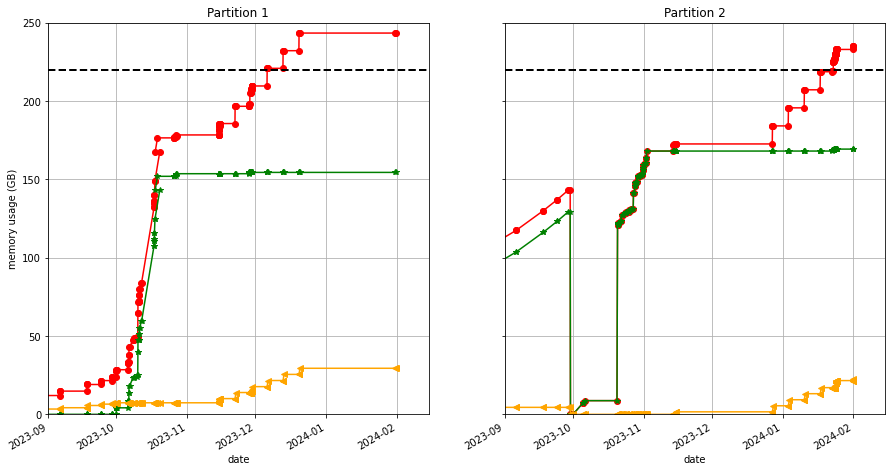

In [42]:
xlim = (DT(2023,9,1,0,0,0),DT(2024,2,15,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)
# plt.savefig('/home/calchetti/MPStemp/pics/TM/total_v5.1.png')

# fname = '/home/calchetti/MPStemp/PHI_TMtool/TM_NMP1_v2.csv'
# PHI.save(fname)

/tmp/ipykernel_1384099/4027334492.py:217: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')


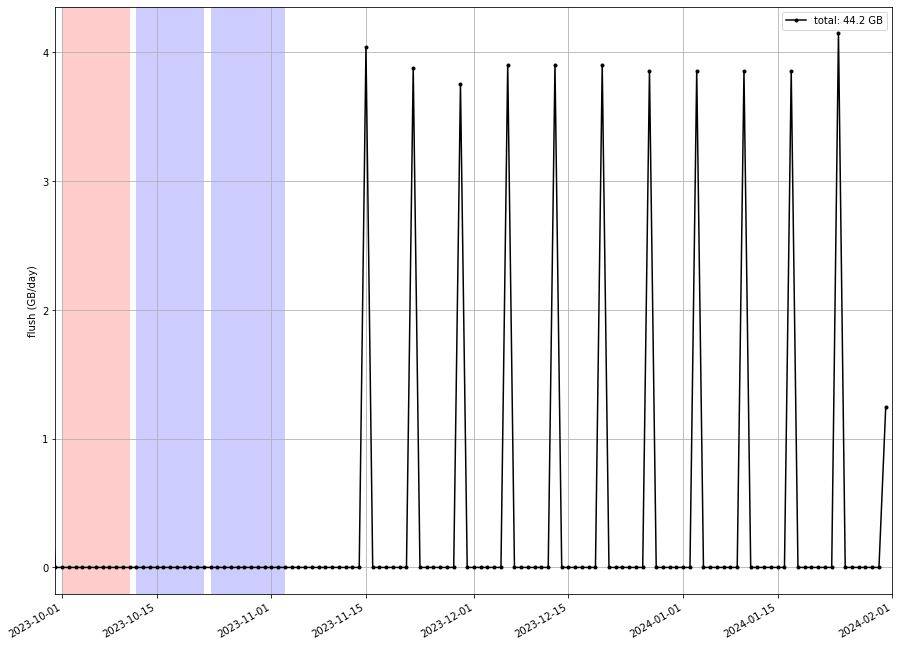

In [42]:
xlim = (DT(2023,9,30,0,0,0),DT(2024,2,1,0,0,0))
tt, tm1, tm2 = plot_flush_per_day(PHI,xlim,values=True)
ylim = plt.gca().get_ylim()
plt.fill_betweenx(ylim,DT(2023,10,1),DT(2023,10,11),facecolor='red',alpha=.2);
plt.fill_betweenx(ylim,DT(2023,10,12),DT(2023,10,22),facecolor='blue',alpha=.2);
plt.fill_betweenx(ylim,DT(2023,10,23),DT(2023,11,3),facecolor='blue',alpha=.2);
plt.ylim(ylim);
# 1 GB = 2.2h of flushing

In [40]:
rsw10 = [DT(2023,9,30,0,0,0),DT(2023,10,12,0,0,0)]
rsw11 = [DT(2023,10,12,0,0,0),DT(2023,10,23,0,0,0)]
rsw12 = [DT(2023,10,23,0,0,0),DT(2023,11,3,0,0,0)]

rsw10_1 = tm1[np.where(np.logical_and(tt>=rsw10[0].date(),tt<rsw10[1].date()))] * 1e9 / 2**20
rsw10_2 = tm2[np.where(np.logical_and(tt>=rsw10[0].date(),tt<rsw10[1].date()))]* 1e9 / 2**20

rsw11_1 = tm1[np.where(np.logical_and(tt>=rsw11[0].date(),tt<rsw11[1].date()))]* 1e9 / 2**20
rsw11_2 = tm2[np.where(np.logical_and(tt>=rsw11[0].date(),tt<rsw11[1].date()))]* 1e9 / 2**20

rsw12_1 = tm1[np.where(np.logical_and(tt>=rsw12[0].date(),tt<rsw12[1].date()))]* 1e9 / 2**20
rsw12_2 = tm2[np.where(np.logical_and(tt>=rsw12[0].date(),tt<rsw12[1].date()))]* 1e9 / 2**20

out_1 = tm1[np.where(tt>=rsw12[1].date())]* 1e9 / 2**20
out_2 = tm2[np.where(tt>=rsw12[1].date())]* 1e9 / 2**20

print('(MiB)\tNAND-1\tNAND-2\ttotal')
print(f'RSW-10\t{int(round(rsw10_1.sum(),0))}\t{int(round(rsw10_2.sum(),0))}\t{int(round(rsw10_1.sum()+rsw10_2.sum(),0))}')
print(f'RSW-11\t{int(round(rsw11_1.sum(),0))}\t{int(round(rsw11_2.sum(),0))}\t{int(round(rsw11_1.sum()+rsw11_2.sum(),0))}')
print(f'RSW-12\t{int(round(rsw12_1.sum(),0))}\t{int(round(rsw12_2.sum(),0))}\t{int(round(rsw12_1.sum()+rsw12_2.sum(),0))}')
print(f'total\t{int(round(rsw10_1.sum()+rsw11_1.sum()+rsw12_1.sum(),0))}\t{int(round(rsw10_2.sum()+rsw11_2.sum()+rsw12_2.sum(),0))}'+
      f'\t{int(round(rsw10_1.sum()+rsw10_2.sum()+rsw11_1.sum()+rsw11_2.sum()+rsw12_1.sum()+rsw12_2.sum(),0))}')
print('')
print(f'out\t{int(round(out_1.sum(),0))}\t{int(round(out_2.sum(),0))}\t{int(round(out_1.sum()+out_2.sum(),0))}')


(MiB)	NAND-1	NAND-2	total
RSW-10	290	1234	1525
RSW-11	0	137	137
RSW-12	0	137	137
total	290	1509	1800

out	20873	18825	39698


In [43]:
print('DATE\tFLUSH NAND-1 (MiB)\tFLUSH NAND-2 (MiB)')
for tti, tm1i, tm2i in zip(tt,tm1,tm2):
    print(str(tti)+'\t'+'{:.0f}'.format(tm1i*1e9/2**20)+'\t'+'{:.0f}'.format(tm2i*1e9/2**20))

DATE	FLUSH NAND-1 (MiB)	FLUSH NAND-2 (MiB)
2023-04-26	0	0
2023-04-27	0	0
2023-04-28	0	0
2023-04-29	0	0
2023-04-30	0	0
2023-05-01	0	0
2023-05-02	0	825
2023-05-03	0	0
2023-05-04	0	0
2023-05-05	0	0
2023-05-06	0	0
2023-05-07	0	0
2023-05-08	0	0
2023-05-09	0	0
2023-05-10	0	0
2023-05-11	0	0
2023-05-12	0	0
2023-05-13	0	0
2023-05-14	0	0
2023-05-15	0	1478
2023-05-16	0	0
2023-05-17	0	0
2023-05-18	0	0
2023-05-19	0	0
2023-05-20	0	0
2023-05-21	0	0
2023-05-22	0	0
2023-05-23	0	0
2023-05-24	0	656
2023-05-25	0	0
2023-05-26	0	0
2023-05-27	0	0
2023-05-28	0	0
2023-05-29	0	0
2023-05-30	0	0
2023-05-31	0	0
2023-06-01	0	0
2023-06-02	0	0
2023-06-03	0	0
2023-06-04	0	0
2023-06-05	0	0
2023-06-06	0	0
2023-06-07	0	0
2023-06-08	0	0
2023-06-09	0	0
2023-06-10	0	0
2023-06-11	0	0
2023-06-12	0	0
2023-06-13	0	0
2023-06-14	0	0
2023-06-15	0	0
2023-06-16	0	1286
2023-06-17	0	0
2023-06-18	0	0
2023-06-19	0	0
2023-06-20	0	0
2023-06-21	0	0
2023-06-22	0	0
2023-06-23	0	0
2023-06-24	0	0
2023-06-25	0	0
2023-06-26	0	0
2023-06-27	0	0
20

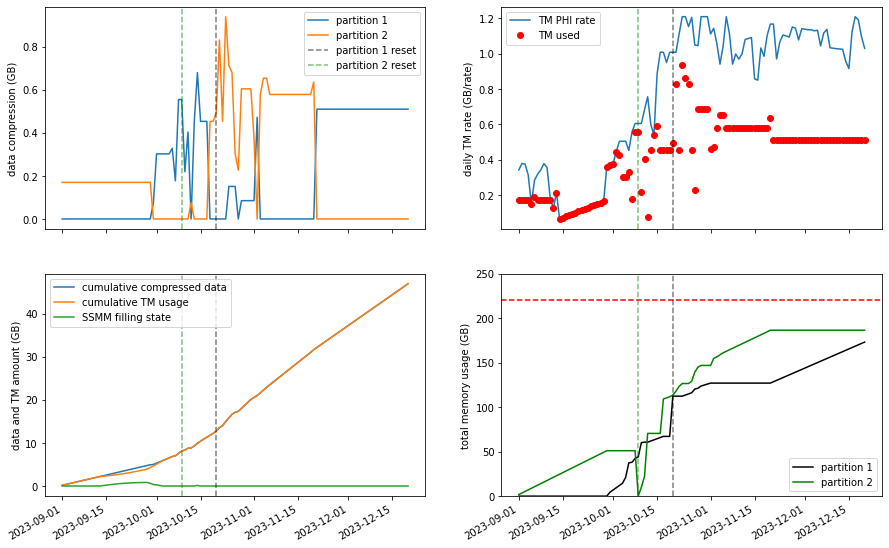

In [55]:
from scipy.interpolate import interp1d
tot1 = np.asarray(PHI.part1.history['occu'])
tot2 = np.asarray(PHI.part2.history['occu'])
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(min(d1),min(d2))
endtime = max(max(d1),max(d2))
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += TD(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

s = np.argsort(d1)

newtot1 = np.zeros(np.size(times))
for i,j in zip(d1,tot1):
    if True:
        ind = np.where(times == i.date())[0]
        newtot1[ind] += j/1e3
newtot1 = np.asarray(newtot1)

newtot2 = np.zeros(np.size(times))
for i,j in zip(d2,tot2):
    if True:
        ind = np.where(times == i.date())[0]
        newtot2[ind] += j/1e3
newtot2 = np.asarray(newtot2)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)


newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)

form1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j<0:
        ind = np.where(times == i.date())[0]
        form1[ind] += j/1e3
form1 = np.asarray(form1)


form2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j<0:
        ind = np.where(times == i.date())[0]
        form2[ind] += j/1e3
form2 = np.asarray(form2)

trig1 = np.where(form1 < 0)[0]
trig2 = np.where(form2 < 0)[0]

x = TM3['date'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
y = TM3['tm_rate'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
z = TM3['duration'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z,fill_value='extrapolate')
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2023,4,1)] *= .2
ynew[times>=datetime.date(2023,4,1)] *= .3

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if newc1[i] > 0 or newc2[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.ylabel('data compression (GB)')
plt.plot(times,newc1,label='partition 1')
plt.plot(times,newc2,label='partition 2')
for i,t in enumerate(trig1):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5,label='partition 1 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for i,t in enumerate(trig2):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5,label='partition 2 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
plt.legend()

plt.subplot(222)
plt.ylabel('daily TM rate (GB/rate)')
plt.plot(times,ynew,label='TM PHI rate')
plt.plot(times,tm_used,'ro',label='TM used')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
# print('total1408 TM used:',round(tm_used.sum(),2),'GB')
# print('total compressed data:',round((newc1+newc2).sum(),2),'GB')
# plt.xlim(datetime.date(2023,1,10),datetime.date(2023,2,5))
plt.subplot(223)
# cond = np.logical_and(times>=FL['date'][0].date(), times<=FL['date'][-1].date())
cond = np.ones(np.size(times),dtype=bool)
plt.ylabel('data and TM amount (GB)')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond]),label='cumulative compressed data')
plt.plot(times[cond],np.cumsum(tm_used[cond]),label='cumulative TM usage')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond])-np.cumsum(tm_used[cond]),label='SSMM filling state')
# plt.plot(FL['date'],-np.cumsum(FL['flush']*2**20/1e9),'m',label='SOOPK FLUSH')
# cond = np.logical_and(FL['date']>DT(2023,1,19,0,0), FL['date']<DT(2023,5,1,0,0))
# plt.plot(FL['date'][cond],-np.cumsum(FL['flush'][cond]*2**20/1e9),'m',label='SOOPK FLUSH')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.subplot(224)
plt.ylabel('total memory usage (GB)')
plt.plot(times,np.cumsum(newtot1),'k',label='partition 1')
plt.plot(times,np.cumsum(newtot2),'g',label='partition 2')
plt.legend()
plt.ylim(0,250)
plt.axhline(220,linestyle='--',color='r')
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.gcf().autofmt_xdate()
# plt.savefig('/home/calchetti/MPStemp/pics/TM/tm_v5.1.png')

In [132]:
print('Total amount of TM used:',round(tm_used.sum(),2),'GB')
print('Total amount of compressed data:',round((newc1+newc2).sum(),2),'GB')

Total amount of TM used: 50.56 GB
Total amount of compressed data: 50.56 GB


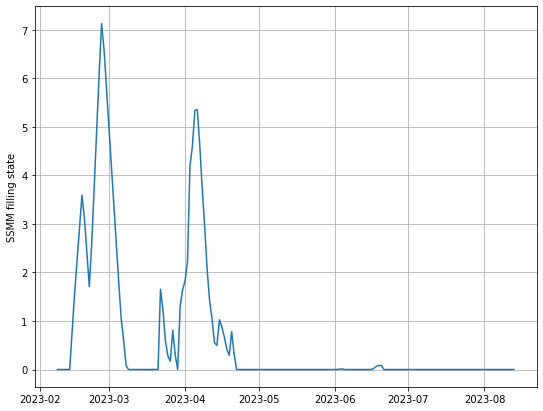

In [133]:
plt.figure(figsize=(9,7))
plt.plot(times,np.cumsum(newc1+newc2)-np.cumsum(tm_used))
plt.ylabel('SSMM filling state')
plt.grid()

In [134]:
(newc1+newc2)[times>datetime.date(2023,3,15)].sum()

34.997348592

In [135]:
PHI.part1.history.keys()
r1 = np.asarray(PHI.part1.history['raw'])[1:]
r2 = np.asarray(PHI.part2.history['raw'])[1:]
f1 = np.asarray(PHI.part1.history['compr'])[1:]
f2 = np.asarray(PHI.part2.history['compr'])[1:]
c1 = np.asarray(PHI.part1.history['crop'])[1:]
c2 = np.asarray(PHI.part2.history['crop'])[1:]
p1 = np.asarray(PHI.part1.history['proc'])[1:]
p2 = np.asarray(PHI.part2.history['proc'])[1:]
k1 = np.asarray(PHI.part1.history['pack'])[1:]
k2 = np.asarray(PHI.part2.history['pack'])[1:]
s1 = np.asarray(PHI.part1.history['start'])[1:]
s2 = np.asarray(PHI.part2.history['start'])[1:]
e1 = np.asarray(PHI.part1.history['end'])[1:]
e2 = np.asarray(PHI.part2.history['end'])[1:]

ind1 = []
for i in range(s1.size):
    if r1[i] < 0:
        ind1 += [-.6]
    elif r1[i] != 0:
        ind1 += [.3]
    elif c1[i] != 0:
        ind1 += [1.3]
    elif k1[i] != 0:
        ind1 += [2.3]
    elif f1[i] != 0:
        ind1 += [3.3]
    elif p1[i] != 0:
        ind1 += [4.3]
    else:
#         print(i)
        ind1 += [0]
ind1 = np.asarray(ind1)    
ind2 = []
for i in range(s2.size):
    if r2[i] < 0:
        ind2 += [-.3]
    elif r2[i] != 0:
        ind2 += [.6]
    elif c2[i] != 0:
        ind2 += [1.6]
    elif k2[i] != 0:
        ind2 += [2.6]
    elif f2[i] != 0:
        ind2 += [3.6]
    elif p2[i] != 0:
        ind2 += [4.6]
    else:
#         print(i)
        ind2 += [0]
ind2 = np.asarray(ind2)    

import matplotlib.dates as mdates


0

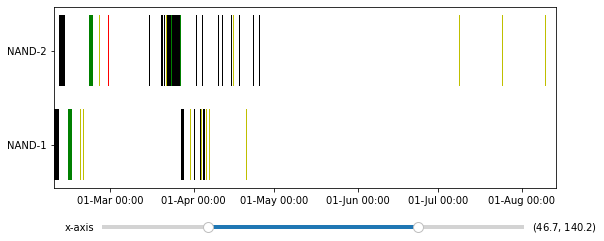

In [136]:
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(bottom=0.25)
# plt.barh(ind1,e1-s1,.3, left=s1)
# plt.barh(ind2,e2-s2,.3, left=s2)
# plt.gcf().autofmt_xdate()
# plt.xlim(min(s1[:10].min(),s2[:10].min()), max(e1[:10].max(),e2[:10].max()))
plt.barh(1,(e1-s1)[ind1==-.6],.75,left=s1[ind1==-.6],color='r')
plt.barh(1,(e1-s1)[ind1==.3],.75,left=s1[ind1==.3],color='k')
plt.barh(1,(e1-s1)[ind1==1.3],.75,left=s1[ind1==1.3],color='b')
plt.barh(1,(e1-s1)[ind1==2.3],.75,left=s1[ind1==2.3],color='g')
plt.barh(1,(e1-s1)[ind1==3.3],.75,left=s1[ind1==3.3],color='y')
plt.barh(1,(e1-s1)[ind1==4.3],.75,left=s1[ind1==4.3],color='m')

plt.barh(2,(e2-s2)[ind2==-.3],.75,left=s2[ind2==-.3],color='r')
plt.barh(2,(e2-s2)[ind2==.6],.75,left=s2[ind2==.6],color='k')
plt.barh(2,(e2-s2)[ind2==1.6],.75,left=s2[ind2==1.6],color='b')
plt.barh(2,(e2-s2)[ind2==2.6],.75,left=s2[ind2==2.6],color='g')
plt.barh(2,(e2-s2)[ind2==3.6],.75,left=s2[ind2==3.6],color='y')
plt.barh(2,(e2-s2)[ind2==4.6],.75,left=s2[ind2==4.6],color='m')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
# plt.yticks([-.6,-.3,.3,.6,1.3,1.6,2.3,2.6,3.3,3.6],['N1-Format','N2-Format','N1-Obs','N2-Obs','N1-Crop','N2-Crop','N1-Pack','N2-Pack','N1-Flush','N2-Flush','N1-Proc','N2-Proc']);
# ax.set_yticks([-.6,-.3,.3,.6,1.3,1.6,2.3,2.6,3.3,3.6],['N1-Format','N2-Format','N1-Obs','N2-Obs','N1-Crop','N2-Crop','N1-Pack','N2-Pack','N1-Flush','N2-Flush']);
ax.set_yticks([1,2],['NAND-1','NAND-2']);

from matplotlib.widgets import RangeSlider # , Button, RadioButtons

# axcolor = 'lightgoldenrodyellow'
slider_ax = fig.add_axes([0.2, 0.1, 0.65, 0.03])

min0 = min(s1.min(),s2.min())
max0 = max(e1.max(),e2.max())

slider = RangeSlider(slider_ax, "x-axis", (min0-min0).total_seconds()/60/60/24, (max0-min0).total_seconds()/60/60/24)

def update(val):    
    ax.set_xlim([min0+TD(days=val[0]),min0+TD(days=val[1])])

slider.on_changed(update)
# plt.show()


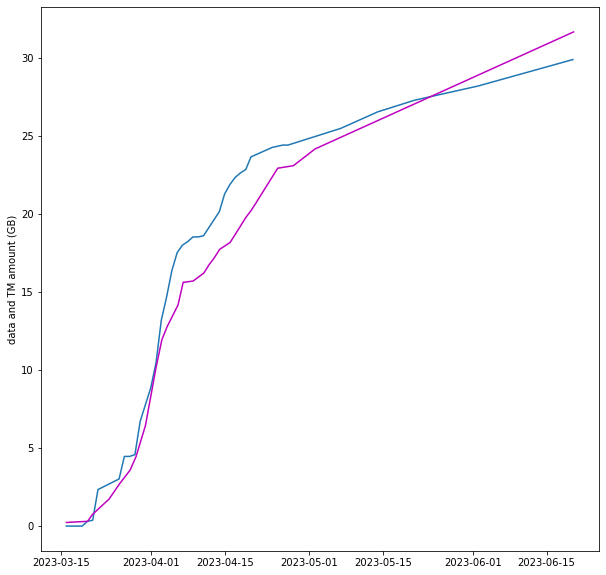

In [137]:
cond = np.logical_and(times>=FL['date'][0].date(), times<=FL['date'][-1].date())
plt.figure(figsize=(10,10))
plt.ylabel('data and TM amount (GB)')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond]),label='cumulative compressed data')
# plt.plot(times[cond],np.cumsum(tm_used[cond]),label='cumulative TM usage')
# plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond])-np.cumsum(tm_used[cond]),label='SSMM filling state')
plt.plot(FL['date'],-np.cumsum(FL['flush']*2**20/1e9),'m',label='SOOPK FLUSH')
# plt.xlim(DT(2023,3,15),DT(2023,4,10)); plt.ylim(0,20)
